In [52]:
# this code is needed to ensure my working directory is the same as where the dataset is
import os
os.chdir('C:\\Users\\wyman\\Desktop\\701IntroProject\\INM701')


The dataset is 1,000,000 rows but a sample size of 10000 is used to save time. However, it is stratified to maintain the same fraud ratio.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE, trustworthiness
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score

df = pd.read_csv('data/card_transdata.csv')

# Get counts of fraud and non-fraud cases
fraud_count = df['fraud'].value_counts()
min_count = fraud_count.min()

# Separate fraud and non-fraud cases
fraud_df = df[df['fraud'] == 1].sample(n=5000, random_state=42)
non_fraud_df = df[df['fraud'] == 0].sample(n=5000, random_state=42)

# Combine the balanced datasets
df = pd.concat([fraud_df, non_fraud_df])

# Shuffle the final dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

This block normalizes the numeric features using StandardScaler to ensure that the GMM algorithm performs effectively. StandardScaler normalizes the data such that the Mean equals 0 and the Standard Deviation equals 1. The binary columns are left unchanged.

In [54]:
# separate features and labels
X = df.drop(columns=['fraud'], axis=1) 
y = df['fraud'] 

# separate binary columns
binary_columns = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]

# separate continuous columns
continuous_columns = [col for col in X.columns if col not in binary_columns]

# scale only the continuous columns
scaler = StandardScaler()
X_scaled_continuous = scaler.fit_transform(df[continuous_columns])

# combine binary and scaled continuous data
X_scaled = pd.concat(
    [pd.DataFrame(X_scaled_continuous, columns=continuous_columns), X[binary_columns].reset_index(drop=True)],
    axis=1
)

# check that the classification labels were split properly
print("\nValue Counts for Target Labels:")
print(y.value_counts())
original_fraud_ratio = y.mean()
print(f"Fraud ratio: {original_fraud_ratio}")


Value Counts for Target Labels:
fraud
0.0    5000
1.0    5000
Name: count, dtype: int64
Fraud ratio: 0.5


### Dimensionality Reduction Functions

In [55]:
def apply_pca(X, variance_threshold): # apply PCA dimension reduction to a given dataset
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

def apply_tsne(X, perplexity, learning_rate=200): # apply t-SNE dimension reduction to a given dataset
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate=learning_rate)
    X_tsne = tsne.fit_transform(X)
    return X_tsne, tsne

### Modeling Functions

In [56]:
def run_gmm_cv(
    X, y, method=None, n_splits=5,
    pca_threshold=None, pca_clusters=None,
    tsne_perplexity=None, tsne_clusters=None):
  
    # apply dimensionality reduction if specified
    if method == "PCA":
        if pca_threshold is None or pca_clusters is None:
            raise ValueError("PCA requires pca_threshold and pca_clusters to be defined.")
        print("Applying PCA...")
        X_reduced, _ = apply_pca(X, pca_threshold)
        n_clusters = pca_clusters
    elif method == "TSNE":
        if tsne_perplexity is None or tsne_clusters is None:
            raise ValueError("t-SNE requires tsne_perplexity and tsne_clusters to be defined.")
        print("Applying t-SNE...")
        X_reduced, _ = apply_tsne(X, tsne_perplexity)
        n_clusters = tsne_clusters
    elif method is None:
        print("No dimensionality reduction...")
        X_reduced = X
        n_clusters = 2
    else:
        raise ValueError("Method must be 'PCA', 'TSNE', or None")
    
    X_reduced = np.array(X_reduced)
    y_np = np.array(y)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    
    print(f"\nRunning Cross-Validation ({'No Dimensionality Reduction' if method is None else method})...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_reduced, y)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_val = y_np[val_idx]
        
        # evaluate GMM on the current fold
        try:
            accuracy, precision, recall, f1 = evaluate_gmm_fold(
                X_train, X_val, y_val, n_clusters, original_fraud_ratio
            )
            fold_results.append((accuracy, precision, recall, f1))
            print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
        except Exception as e:
            print(f"Error in fold {fold + 1}: {e}")
    
    if not fold_results:
        raise ValueError("No successful folds. Check your data and parameters.")
    
    avg_metrics = np.mean(fold_results, axis=0)
    print(f"\nAverage Metrics Across Folds: Accuracy: {avg_metrics[0]:.4f}, Precision: {avg_metrics[1]:.4f}, "
          f"Recall: {avg_metrics[2]:.4f}, F1-Score: {avg_metrics[3]:.4f}")
    
    return avg_metrics


def grid_search_gmm(X, y, n_clusters_range, method_name="", scoring='silhouette', verbose=True):

    if isinstance(scoring, str):
        scoring = [scoring]

    results = []
    aggregated_performance = {}

    # loop through all cluster amounts and calculate the best score for each of htem
    for n_clusters in n_clusters_range:
        score = run_gmm_cv(X, y, n_clusters, cv=5, scoring=scoring)

        # If multiple metrics, pick the first metric value to display and store
        displayed_score = next(iter(score.values()))

        results.append((method_name, n_clusters, displayed_score))

        if verbose:
            print(
                f"{method_name} - n_clusters: {n_clusters}, "
                f"Mean: {displayed_score:.4f}"
            )

        # update the aggregated performance list with the new score
        if n_clusters not in aggregated_performance:
            aggregated_performance[n_clusters] = []
        aggregated_performance[n_clusters].append(displayed_score)

    return results, aggregated_performance

def evaluate_gmm_fold(X_train, X_val, y_val, n_clusters, original_fraud_ratio):
    gmm = GaussianMixture(n_components=n_clusters, n_init=50, covariance_type='tied', random_state=42)
    gmm.fit(X_train)
    val_clusters = gmm.predict(X_val)
    mapped_val_clusters = map_clusters_to_labels(val_clusters, y_val, original_fraud_ratio)

    accuracy = accuracy_score(y_val, mapped_val_clusters)
    precision = precision_score(y_val, mapped_val_clusters, pos_label=1, zero_division=0)
    recall = recall_score(y_val, mapped_val_clusters, pos_label=1, zero_division=0)
    f1 = f1_score(y_val, mapped_val_clusters, pos_label=1, zero_division=0)

    return accuracy, precision, recall, f1

# sssigns a cluster to fraud  if the proportion of fraud cases within it 
# exceeds the dataset's overall fraud ratio 
def map_clusters_to_labels(clusters, y_val, original_fraud_ratio):
    results_df = pd.DataFrame({'Cluster': clusters, 'Actual': y_val})
    cluster_label_mapping = pd.crosstab(results_df['Cluster'], results_df['Actual'])
    cluster_to_label = {}
    for cluster in cluster_label_mapping.index:
        fraud_ratio_in_cluster = cluster_label_mapping.loc[cluster, 1.0] / cluster_label_mapping.loc[cluster].sum()
        cluster_to_label[cluster] = 1.0 if fraud_ratio_in_cluster > original_fraud_ratio else 0.0
    mapped_labels = [cluster_to_label[c] for c in clusters]
    return mapped_labels


def run_dimensionality_reduction_and_cv(X, y, method=None, n_splits=5,
                                        pca_threshold=None, pca_clusters=None,
                                        tsne_perplexity=None, tsne_clusters=None):    
    # apply dimension reduction
    if method == "PCA":
        print("Applying PCA...")
        X_reduced, pca_obj = apply_pca(X, pca_threshold)
        n_clusters = pca_clusters
    elif method == "TSNE":
        print("Applying t-SNE...")
        X_reduced, tsne_obj = apply_tsne(X, tsne_perplexity)
        n_clusters = tsne_clusters
    elif method is None:
        print("No dimensionality reduction...")
        X_reduced = X
        n_clusters = 2
    else:
        raise ValueError("Method must be 'PCA', 'TSNE', or None")

    X_reduced = np.array(X_reduced)
    y_np = np.array(y)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    print(f"\nRunning Cross-Validation ({'No Dimensionality Reduction' if method is None else method})...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_reduced, y)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_val = y_np[val_idx]

        # call the helper function to evaluate the fold
        accuracy, precision, recall, f1 = evaluate_gmm_fold(
            X_train, X_val, y_val, n_clusters, original_fraud_ratio
        )
        fold_results.append((accuracy, precision, recall, f1))

        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    avg_metrics = np.mean(fold_results, axis=0)
    print(f"\nAverage Metrics Across Folds: Accuracy: {avg_metrics[0]:.4f}, Precision: {avg_metrics[1]:.4f}, "
          f"Recall: {avg_metrics[2]:.4f}, F1-Score: {avg_metrics[3]:.4f}")

    return avg_metrics



# evaluate each testing function based on a different dimensional reduction using the optimal parameters
def evaluate_on_test_set(X_train, y_train, X_test, y_test, method=None,
                         pca_threshold=None, pca_clusters=None,
                         tsne_perplexity=None, tsne_clusters=None):    # Apply dimension reduction if needed
    if method == "PCA":
        X_train, pca_obj = apply_pca(X_train, pca_threshold)
        X_test = pca_obj.transform(X_test)
        n_clusters = pca_clusters
    elif method == "t-SNE":
        X_train, tsne_obj = apply_tsne(X_train, tsne_perplexity)
        X_test, _ = apply_tsne(X_test, tsne_perplexity) # though this is not ideal for t-SNE transform
        n_clusters = tsne_clusters
    elif method is None:
        n_clusters = 2
    else:
        raise ValueError("Invalid dimensionality reduction method")

    # Fit GMM
    gmm = GaussianMixture(n_components=n_clusters, n_init=50, covariance_type='tied', random_state=42)
    gmm.fit(X_train)
    test_clusters = gmm.predict(X_test)

    mapped_test_clusters = map_clusters_to_labels(test_clusters, y_test, original_fraud_ratio)
    cm = confusion_matrix(y_test, mapped_test_clusters)

    return cm, X_test, test_clusters


### Graphing Functions

In [57]:
def plot_line_performance(x_values, y_values, title, xlabel, ylabel, labels=None):
    plt.figure(figsize=(10,6))
    if labels is None:
        labels = [None]*len(y_values)
    for y, lbl in zip(y_values, labels):
        plt.plot(x_values, y, marker='o', label=lbl)
    if any(labels):
        plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def plot_conf_matrix(cm, class_names=["Non-Fraud","Fraud"], title="Confusion Matrix"):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


### PCA Optimization

PCA is run with various combinations of retained variance thresholds and cluster amount combinations to determine the optimal set of parameters based primarily on the silhouette score which is a value that measures how well connected the clusters are. The best combination of parameters is maintained for later testing. As expected, 2 clusters are usually optimal because the problem is trying to classify between two classes, fraud and non-fraud.

PCA Threshold: 0.7, Clusters: 2, Silhouette Score: 0.8108, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, Clusters: 3, Silhouette Score: 0.7541, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, Clusters: 4, Silhouette Score: 0.7351, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.8, Clusters: 2, Silhouette Score: 0.8108, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.8, Clusters: 3, Silhouette Score: 0.7541, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.8, Clusters: 4, Silhouette Score: 0.7351, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.9, Clusters: 2, Silhouette Score: 0.7876, Retained Components: 4, Removed Components: 3
PCA Threshold: 0.9, Clusters: 3, Silhouette Score: 0.2400, Retained Components: 4, Removed Components: 3
PCA Threshold: 0.9, Clusters: 4, Silhouette Score: 0.2724, Retained Components: 4, Removed Components: 3
PCA Threshold: 0.95, Clusters: 2, Silhouette Score: 0.7

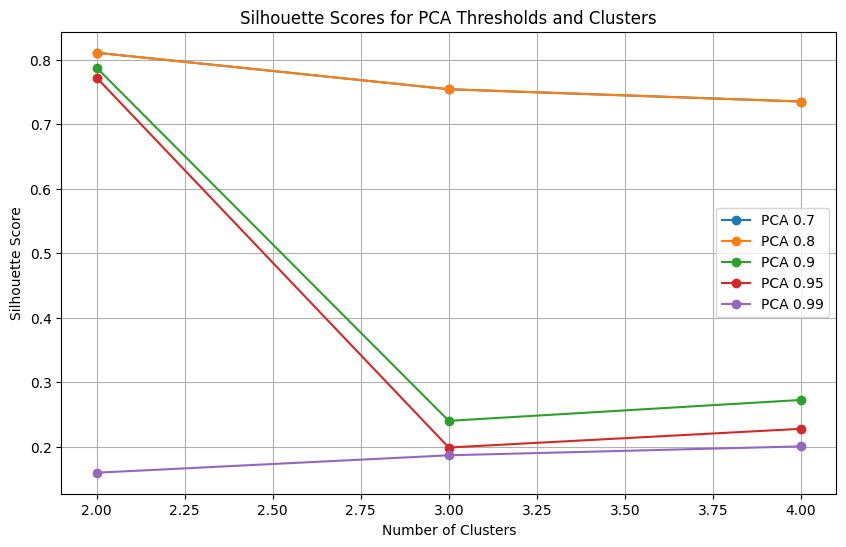

In [58]:
# define PCA thresholds and cluster range
pca_thresholds = [0.70, 0.80, 0.90, 0.95, 0.99]
cluster_range = range(2, 5)

# store (pca_threshold, n_clusters, silhouette_score)
pca_results = []  

original_components = X_scaled.shape[1]

# loop through each combination of hyperparameters to findthe best PCA threshold
for pca_threshold in pca_thresholds:
    # helper function to apply PCA
    X_pca, pca_obj = apply_pca(X_scaled, pca_threshold)
    
    retained_components = pca_obj.n_components_
    removed_components = original_components - retained_components

    for n_clusters in cluster_range:
        gmm = GaussianMixture(n_components=n_clusters, n_init=50, covariance_type='tied', random_state=42)
        labels = gmm.fit_predict(X_pca)

        silhouette_avg = silhouette_score(X_pca, labels)
        pca_results.append((pca_threshold, n_clusters, silhouette_avg))
        print(
            f"PCA Threshold: {pca_threshold}, Clusters: {n_clusters}, "
            f"Silhouette Score: {silhouette_avg:.4f}, "
            f"Retained Components: {retained_components}, Removed Components: {removed_components}"
        )

# find the best combination of PCA threshold and number of clusters
best_pca_threshold, best_pca_clusters, best_pca_silhouette = max(pca_results, key=lambda x: x[2])
print(f"\nBest PCA Threshold: {best_pca_threshold}, Best PCA Clusters: {best_pca_clusters}, Best PCA Silhouette Score: {best_pca_silhouette:.4f}")

# visualize silhouette cores
results_array = np.array(pca_results)
plt.figure(figsize=(10, 6))


for threshold in pca_thresholds:
    scores = results_array[results_array[:, 0] == threshold][:, 2].astype(float)
    plt.plot(cluster_range, scores, marker='o', label=f'PCA {threshold}')

plt.title("Silhouette Scores for PCA Thresholds and Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid()
plt.show()

PCA retains the highest silouette score with a threshold of either 0.7 or 0.8 because they both retain the same amount of components. This graph also confirms the idea that 2 clusters will have optimal performance because there are only 2 classes.

### t-SNE Optimization

t-SNE is run with a various range of perplexities of and cluster amount combinations to determine the optimal set of parameters  based primarily on the silhouette score and the ARI. The trustworthiness is useful to verify that the local structure of the data is properly reflected after the dimension reduction, but the other metrics better measure how well the data is preservered after being reduced. t-SNE doesn't always prefer 2 clusters. I think this is because this method always reduces the data to 2 dimensions (compared to PCA which is variable) which can substantially alter the way the data is preserved, causing the model to recognize more clusters.

t-SNE Perplexity: 5, Clusters: 2, Silhouette Score: 0.3356, ARI: 0.1700, Trustworthiness: 0.9996
t-SNE Perplexity: 5, Clusters: 3, Silhouette Score: 0.3589, ARI: 0.1981, Trustworthiness: 0.9996
t-SNE Perplexity: 5, Clusters: 4, Silhouette Score: 0.3499, ARI: 0.2051, Trustworthiness: 0.9996
t-SNE Perplexity: 10, Clusters: 2, Silhouette Score: 0.3376, ARI: 0.2082, Trustworthiness: 0.9997
t-SNE Perplexity: 10, Clusters: 3, Silhouette Score: 0.3628, ARI: 0.2237, Trustworthiness: 0.9997
t-SNE Perplexity: 10, Clusters: 4, Silhouette Score: 0.3464, ARI: 0.2326, Trustworthiness: 0.9997
t-SNE Perplexity: 20, Clusters: 2, Silhouette Score: 0.3471, ARI: 0.1649, Trustworthiness: 0.9997
t-SNE Perplexity: 20, Clusters: 3, Silhouette Score: 0.2868, ARI: 0.3125, Trustworthiness: 0.9997
t-SNE Perplexity: 20, Clusters: 4, Silhouette Score: 0.3691, ARI: 0.1709, Trustworthiness: 0.9997
t-SNE Perplexity: 30, Clusters: 2, Silhouette Score: 0.3457, ARI: 0.2326, Trustworthiness: 0.9997
t-SNE Perplexity: 30, C

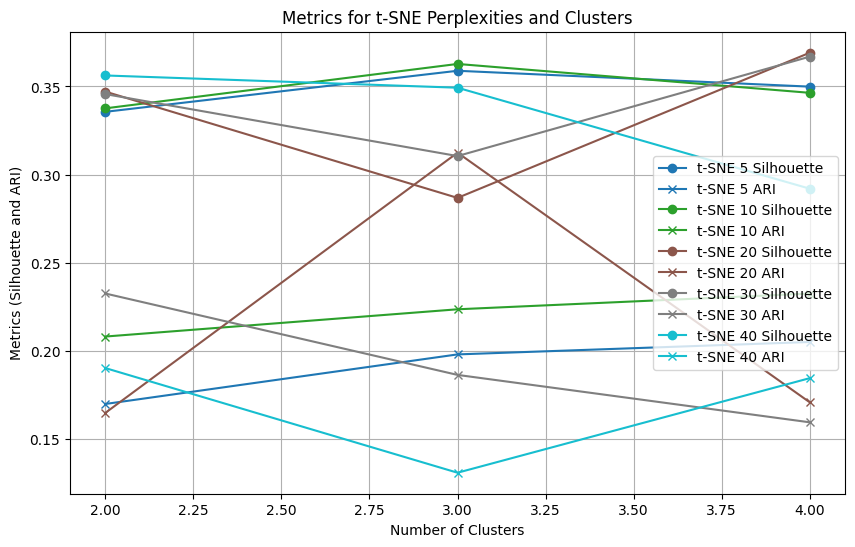

In [59]:
# define t-SNE perplexity values and cluster range
tsne_perplexities = [5, 10, 20, 30, 40]
cluster_range = range(2, 5)

# so store (perplexity, n_clusters, silhouette_score, ARI, trustworthiness)
tsne_results = []  

# iterate over t-SNE perplexities
for perplexity in tsne_perplexities:

    # apply t-SNE with the current perplexity
    X_tsne, tsne_obj = apply_tsne(X_scaled, perplexity, learning_rate=200)


    # calculate trustworthiness for this t-SNE trial
    trust = trustworthiness(X_scaled, X_tsne, n_neighbors=5)

    # iterate over the range of clusters
    for n_clusters in cluster_range:
        # train gmm
        gmm = GaussianMixture(n_components=n_clusters, n_init=50, covariance_type='tied', random_state=42)
        labels = gmm.fit_predict(X_tsne)

        # calculate silhouette score and ARI
        silhouette_avg = silhouette_score(X_tsne, labels)
        ari_score = adjusted_rand_score(y, labels)

        # store results
        tsne_results.append((perplexity, n_clusters, silhouette_avg, ari_score, trust))

        # print details
        print(
            f"t-SNE Perplexity: {perplexity}, Clusters: {n_clusters}, "
            f"Silhouette Score: {silhouette_avg:.4f}, ARI: {ari_score:.4f}, "
            f"Trustworthiness: {trust:.4f}"
        )

# find the optimal parameters based on ARI and silhouette score, preferring closer to 2 clusters
best_tsne_trial = max(
    tsne_results,
    key=lambda x: (x[3], x[2], -(x[1] == 2))  # prioritize ARI, then silhouette, with slight preference for 2 clusters
)
best_tsne_perplexity, best_tsne_clusters, best_tsne_silhouette, best_tsne_ari, best_tsne_trustworthiness = best_tsne_trial

# print the optimal parameters
print(f"\nBest t-SNE Perplexity: {best_tsne_perplexity}, Best t-SNE Clusters: {best_tsne_clusters}")
print(f"Best t-SNE Silhouette Score: {best_tsne_silhouette:.4f}, Best t-SNE ARI: {best_tsne_ari:.4f}")
print(f"Best t-SNE Trustworthiness: {best_tsne_trustworthiness:.4f}")

# visualize silhouette scores and ARI for t-SNE
results_array_tsne = np.array(tsne_results)
plt.figure(figsize=(10, 6))

# define a color map for each perplexity
colors = plt.cm.tab10(np.linspace(0, 1, len(tsne_perplexities)))

# extracts each value from each perplexity of t-SNE to be graphed
for i, perplexity in enumerate(tsne_perplexities):
    scores = results_array_tsne[results_array_tsne[:, 0] == perplexity][:, 2].astype(float)
    ari_scores = results_array_tsne[results_array_tsne[:, 0] == perplexity][:, 3].astype(float)
    clusters = results_array_tsne[results_array_tsne[:, 0] == perplexity][:, 1]

    # plot silhouette scores with dots
    plt.plot(clusters, scores, marker='o', label=f't-SNE {perplexity} Silhouette', color=colors[i])
    # plot ARI scores with crosses
    plt.plot(clusters, ari_scores, marker='x', label=f't-SNE {perplexity} ARI', color=colors[i])

plt.title("Metrics for t-SNE Perplexities and Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Metrics (Silhouette and ARI)")
plt.legend()
plt.grid()
plt.show()

There does not seem to be a consistent correlation between the number of clusters and the performance metrics. The graph also shows that t-SNE tends to prefer a smaller perplexity for this dataset, but the performance seems bad regardless.

### Validation Metrics

This block runs cross validation to test the performance metrics with each form of dimension reduction.

Running with no dimensionality reduction
No dimensionality reduction...

Running Cross-Validation (No Dimensionality Reduction)...
Fold 1/5
Accuracy: 0.5155, Precision: 0.9429, Recall: 0.0330, F1-Score: 0.0638
Fold 2/5
Accuracy: 0.5050, Precision: 0.9167, Recall: 0.0110, F1-Score: 0.0217
Fold 3/5
Accuracy: 0.5115, Precision: 0.9259, Recall: 0.0250, F1-Score: 0.0487
Fold 4/5
Accuracy: 0.5105, Precision: 0.8182, Recall: 0.0270, F1-Score: 0.0523
Fold 5/5
Accuracy: 0.5135, Precision: 0.8000, Recall: 0.0360, F1-Score: 0.0689

Average Metrics Across Folds: Accuracy: 0.5112, Precision: 0.8807, Recall: 0.0264, F1-Score: 0.0511

Running PCA
Applying PCA...

Running Cross-Validation (PCA)...
Fold 1/5
Accuracy: 0.5170, Precision: 0.9474, Recall: 0.0360, F1-Score: 0.0694
Fold 2/5
Accuracy: 0.5050, Precision: 0.9167, Recall: 0.0110, F1-Score: 0.0217
Fold 3/5
Accuracy: 0.5115, Precision: 0.9259, Recall: 0.0250, F1-Score: 0.0487
Fold 4/5
Accuracy: 0.5110, Precision: 0.8235, Recall: 0.0280, F1-Score: 

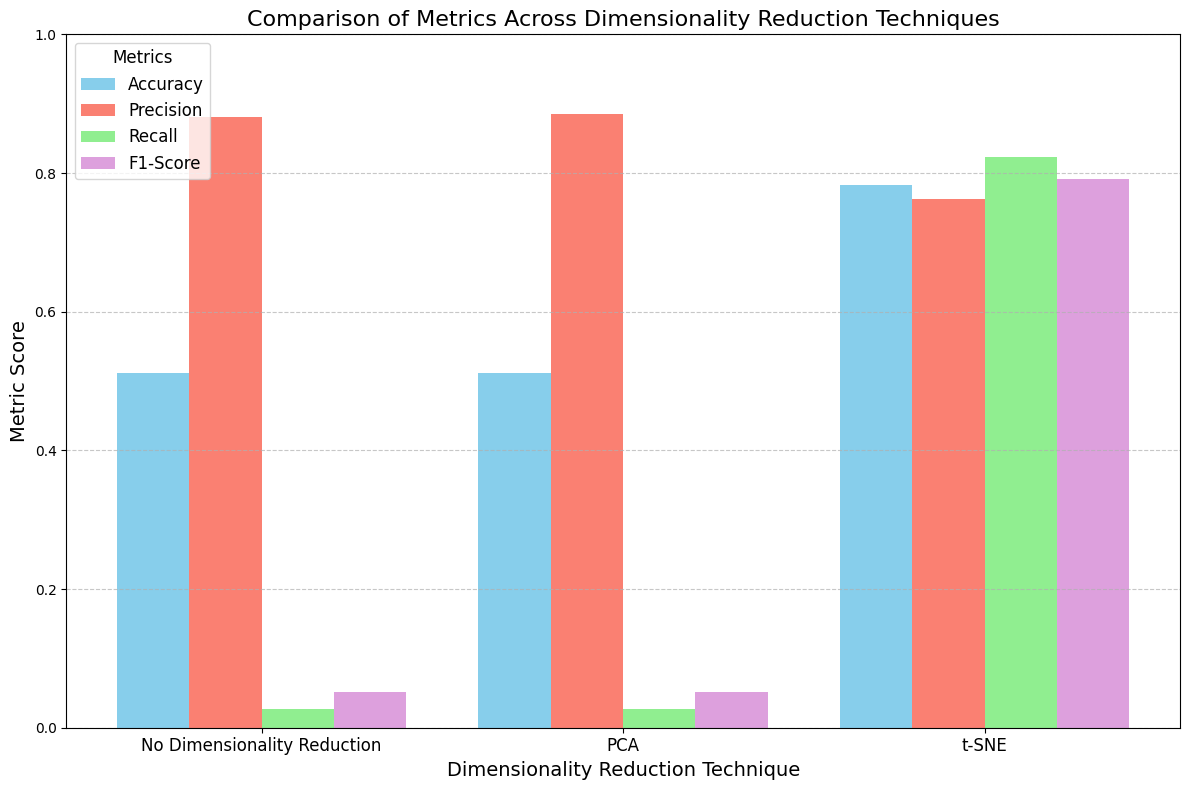

In [60]:
print("Running with no dimensionality reduction")
metrics_no_reduction = run_gmm_cv(
    X_scaled, y, method=None
)

# 2. PCA
print("\nRunning PCA")
metrics_pca = run_gmm_cv(
    X_scaled, y, method="PCA",
    pca_threshold=best_pca_threshold,
    pca_clusters=best_pca_clusters
)

# 3. t-SNE
print("\nRunning t-SNE")
metrics_tsne = run_gmm_cv(
    X_scaled, y, method="TSNE",
    tsne_perplexity=best_tsne_perplexity,
    tsne_clusters=best_tsne_clusters
)

# metrics from the output
metrics = {
    "No Dimensionality Reduction": metrics_no_reduction,
    "PCA": metrics_pca,
    "t-SNE": metrics_tsne
}

# metrics labels and methods
metrics_labels = ["Accuracy", "Precision", "Recall", "F1-Score"]
methods = list(metrics.keys())
scores = np.array([metrics[method] for method in methods])

# the number of methods and metrics
n_methods = len(methods)
n_metrics = len(metrics_labels)

x = np.arange(n_methods)
width = 0.2  

plt.figure(figsize=(12, 8))

colors = ['skyblue', 'salmon', 'lightgreen', 'plum']

for i, metric_label in enumerate(metrics_labels):
    plt.bar(x + i * width, scores[:, i], width, label=metric_label, color=colors[i])

plt.xlabel('Dimensionality Reduction Technique', fontsize=14)
plt.ylabel('Metric Score', fontsize=14)
plt.title('Comparison of Metrics Across Dimensionality Reduction Techniques', fontsize=16)
plt.xticks(x + width * (n_metrics - 1) / 2, methods, fontsize=12)
plt.ylim(0, 1)
plt.legend(title='Metrics', fontsize=12, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


No Reduction and PCA demonstrate a very high precision value but a low recall and F-1 score. This is because the model seems to only be guessing positive when it is extremely sure, leading to a high precision, but this high standard causes the model to overlook other positive cases, which leads to the low recall and F1. t-SNE seems to improve the all metrics because it makes a wider range of predictions.

The following block evaluates the test set after it has been trained on models using data altered by either PCA, t-SNE, or no dimension reduction.

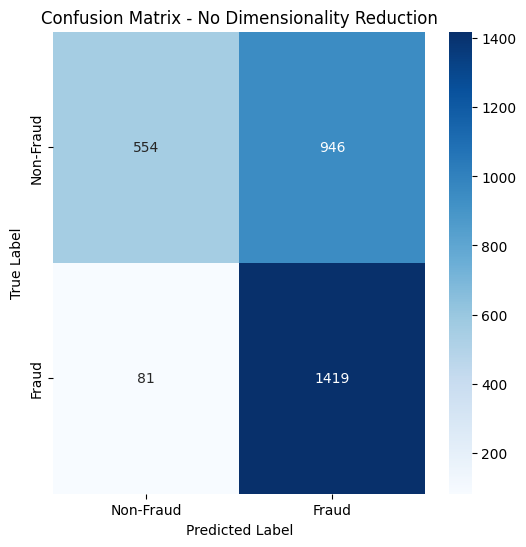

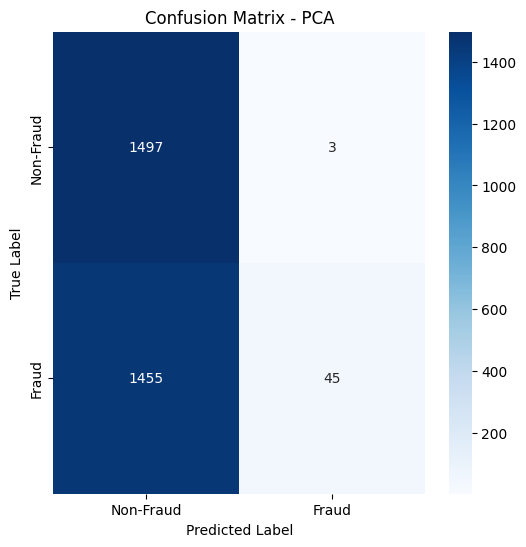

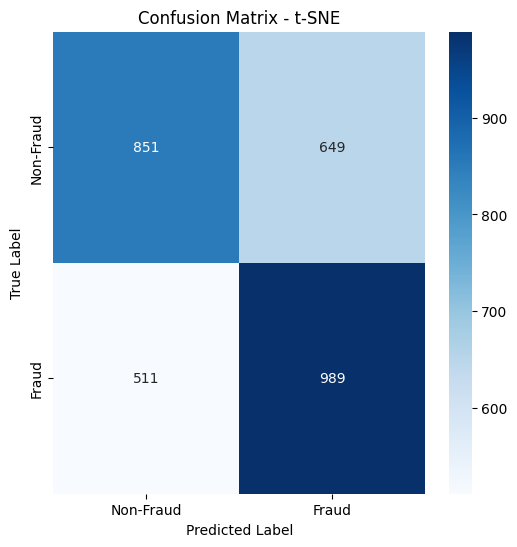

In [61]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# evaluate test sets and store results
methods = ["No Dimensionality Reduction", "PCA", "t-SNE"]
test_conf_matrices = {}
reduced_test_sets = {}
test_clusters_results = {}

for method in methods:
    if method == "No Dimensionality Reduction":
        cm, _, _ = evaluate_on_test_set(
            X_train, y_train, X_test, y_test,
            method=None
        )
    elif method == "PCA":
        cm, X_test_reduced, test_clusters = evaluate_on_test_set(
            X_train, y_train, X_test, y_test,
            method="PCA",
            pca_threshold=best_pca_threshold,
            pca_clusters=best_pca_clusters
        )
        reduced_test_sets[method] = X_test_reduced
        test_clusters_results[method] = test_clusters
    elif method == "t-SNE":
        cm, X_test_reduced, test_clusters = evaluate_on_test_set(
            X_train, y_train, X_test, y_test,
            method="t-SNE",
            tsne_perplexity=best_tsne_perplexity,
            tsne_clusters=best_tsne_clusters
        )
        reduced_test_sets[method] = X_test_reduced
        test_clusters_results[method] = test_clusters
    else:
        raise ValueError(f"Unknown method: {method}")

    test_conf_matrices[method] = cm  # store confusion matrices


# generate heatmaps for the confusion matrices
for method, cm in test_conf_matrices.items():
    plot_conf_matrix(cm, title=f"Confusion Matrix - {method}")

### Dimensional Reduction Analysis
The confusion matrices for each of the reduction techniques provides valuable insight into how dimension reduction affects performance. Without any reduction, the model achieves a high number of true positives and true negatives, it also has a high amount of false positives meaning the model is mistakenly identifying non-fraud cases as fraudulent. The PCA reduced dataset performs drastically different. It predicts non-fraud almost everytime, so while it has a high rate of identifying true negatives, it also predicts an enourmous amount of false negatives. This suggests that because PCA is a linear dimensionality reduction technique, it can't capture the complex, non-linear patterns necessary to identify fraud. t-SNE also offers a much different set of performance metrics, this one being more balanced. While being able to predict all 4 metrics more consistently can lead to some positive real world effects, it still falls behind the others when it comes to actually determining fraud from non fraud which is the ultimate goal of the dataset.

### Cluster Analysis
The following block graphs the clusters in unique colors, with a seperate hollow red triange symbol that highlights the fraud causes.

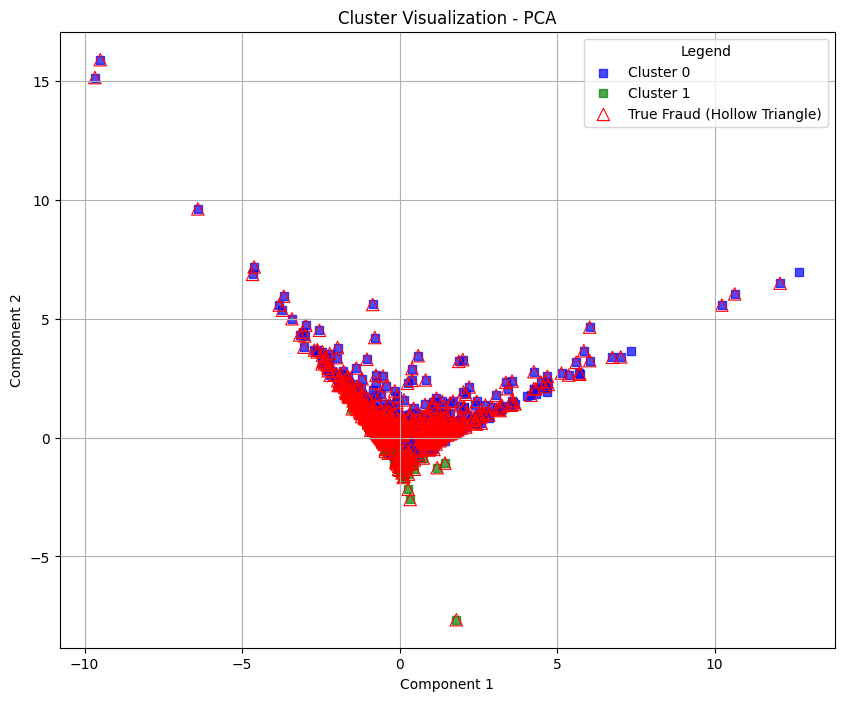

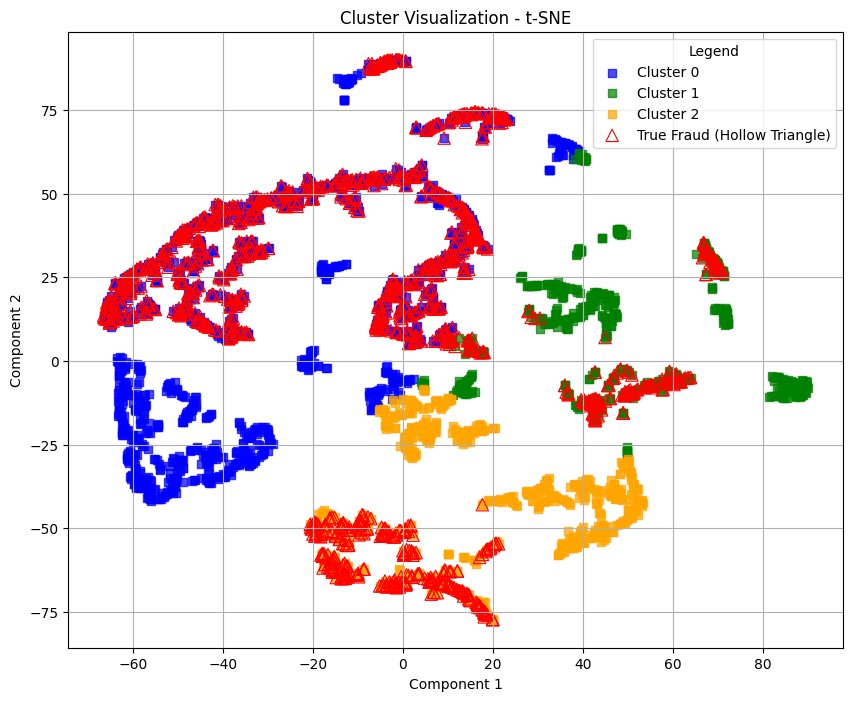

In [62]:
# function to plot clusters dynamically for any number of clusters
def plot_clusters(X_test_transformed, y_test, clusters, method_name):
    plt.figure(figsize=(10, 8))

    # define a distinct color palette for clusters (excluding red)
    cluster_colors = ['blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'brown', 'pink', 'gray']
    unique_clusters = np.unique(clusters)

    if len(unique_clusters) > len(cluster_colors):
        raise ValueError("Too many clusters for the predefined color palette. Add more colors if needed.")

    # plot each cluster with a distinct color
    for i, cluster in enumerate(unique_clusters):
        cluster_indices = (clusters == cluster)
        plt.scatter(
            X_test_transformed[cluster_indices, 0],
            X_test_transformed[cluster_indices, 1],
            c=cluster_colors[i],
            marker='s',
            label=f"Cluster {cluster}",
            alpha=0.7
        )

    # overlay true fraud cases (y_test == 1) as hollow red triangles
    true_fraud_indices = (y_test == 1).values
    plt.scatter(
        X_test_transformed[true_fraud_indices, 0],
        X_test_transformed[true_fraud_indices, 1],
        edgecolor='red',
        facecolor="none",
        marker='^',
        linewidths=0.8,
        s=80,
        label="True Fraud (Hollow Triangle)"
    )

    plt.title(f"Cluster Visualization - {method_name}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Legend", loc="upper right")
    plt.grid(True)
    plt.show()

# graph clusters for PCA and t-SNE
for method in ["PCA", "t-SNE"]:
    if method in reduced_test_sets:
        plot_clusters(
            reduced_test_sets[method],
            y_test,
            test_clusters_results[method],
            method_name=method
        )

The clusters are visualized on each of the graphs, one with a PCA reduction and the other with t-SNE. In each graph, the fraudulunt data points (red hollow triangles) don't seem to correlate with any of the other clusters, instead they are distributed almost randomly throughout the existing clusters. This fact, combined with the lack of reliable testing results after many forms of preprocessing leads me to believe that the GMM model is not well suited for this classification problem.